# The Problem: Churn Prediciton

In [1]:
# common libs I use
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *
from scipy.stats import mstats
%matplotlib inline

## What's the problem?
* Describe the problem informally, e.g. "I need a program that will tell me which tweets will get retweets."

* Describe the problem formally, e.g.
    * Task (T): Classify a tweet that has not been published as going to get retweets or not.
    * Experience (E): A corpus of tweets for an account where some have retweets and some do not.
    * Performance (P): Classification accuracy, the number of tweets predicted correctly out of all tweets considered as a percentage.

* List assumptions, e.g.
    * The specific words used in the tweet matter to the model.
    * The specific user that retweets does not matter to the model.
    * The number of retweets may matter to the model.
    * Older tweets are less predictive than more recent tweets.

* List similar problems, e.g. "A related problem would be email spam discrimination that uses text messages as input data and needs binary classification decision."

## Why do I care about this problem?
* What is my motivation for studying this problem?
* What are the benefits a solution provides?
* How does will a solution be used, e.g. value proposition?

## How should I solve this problem?
* Brainstorm! Literally type everything as a stream of consciousness (coffee helps here)

These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts. These are my thoughts.

* Describe how to solve problem manually
* What data do I have?
* What data do I need?
* What data I **don't** need?
* What do I know the least about in the solution process above?
    * knowledge gap 1
    * knowledge gap 2
* What am I concerned is incorrect in above solution? Find an expert online and ask them about these items
    * concern 1
    * concern 2

# Data Preparation

## ETL
* Data sources:
    * Switcher tables on Lyuba
    * Check Hive tables in unify db: _tmus_porting_ and _p_switcher_list_
* Format, Clean, Sample:
    * Login into Lyuba
    * Join switcher tables against msisdn sums (keep month partitions)
    * Dump joined tables to CSV
    * Load into S3
* Diagnose missing values and anomalies (MVA's)
* What am I going to do w/ MVA's, e.g. simulate? averages? discard records?

## Summarize and visualize attributes
* Data structure
* Distributions
* Histograms
* Pairwise scatterplots

In [2]:
# open data
infile = 'telco.csv'
df = pd.read_csv(infile)
nulls = np.count_nonzero(df.isnull())
print '{:15} {:d}'.format('Observations:', df.shape[0])
print '{:15} {:d}'.format('Features:', df.shape[1])
print '{:15} {:d}'.format('Nulls:', nulls)

Observations:   3333
Features:       21
Nulls:          0


In [3]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.1449145
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.3520674
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,False
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,True


In [4]:
col_names = df.columns.tolist()
print col_names

['state', 'account length', 'area code', 'phone number', 'international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls', 'churn']


In [5]:
# clean-up column names
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

# remove unwanted columns and save as 
to_drop = ['state', 'area_code', 'phone_number'] # for telco demo dataset
#to_drop = ['net_other', ]
df = df.drop(to_drop,axis=1)

# see the data again
df.head(10)

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,118,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,121,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,147,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,117,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,141,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


## Feature Engineering
* Data has complex multi-dimensional structures that ML algos know how to find and exploit to make decisions
* You want to best expose those structures to the algo
* Some structures may be too dense or too complex for the algo to find without help (domain expertise comes into play here)
* Attribute decomposition into simpler components
* Attribute aggregation, e.g. hyperattributes

In [6]:
# preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# one hot encoding
encoder = LabelEncoder()
df.international_plan = encoder.fit_transform(df.international_plan)
df.voice_mail_plan = encoder.fit_transform(df.voice_mail_plan)
df.churn = encoder.fit_transform(df.churn)

# save X, y, and feature names
y = df['churn'].as_matrix()
X = df.drop('churn',axis=1)
features = df.drop('churn',axis=1).columns
X = X.as_matrix().astype(np.float)

# scale and/or transform X
scaler = StandardScaler()
minmax = MinMaxScaler()
X = scaler.fit_transform(X)

# checks
print "%d observations of %d features" % X.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features)
assert(np.mean(X[:,0]) == 1., "Mean is not 1.0")
assert(np.std(X[:,0]) == 0., "STD is not 0.0")
df.head(10)

3333 observations of 17 features
Unique labels: [0 1]
Gut-check features: 17


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,118,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
6,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0
7,147,1,0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0
8,117,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0
9,141,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0


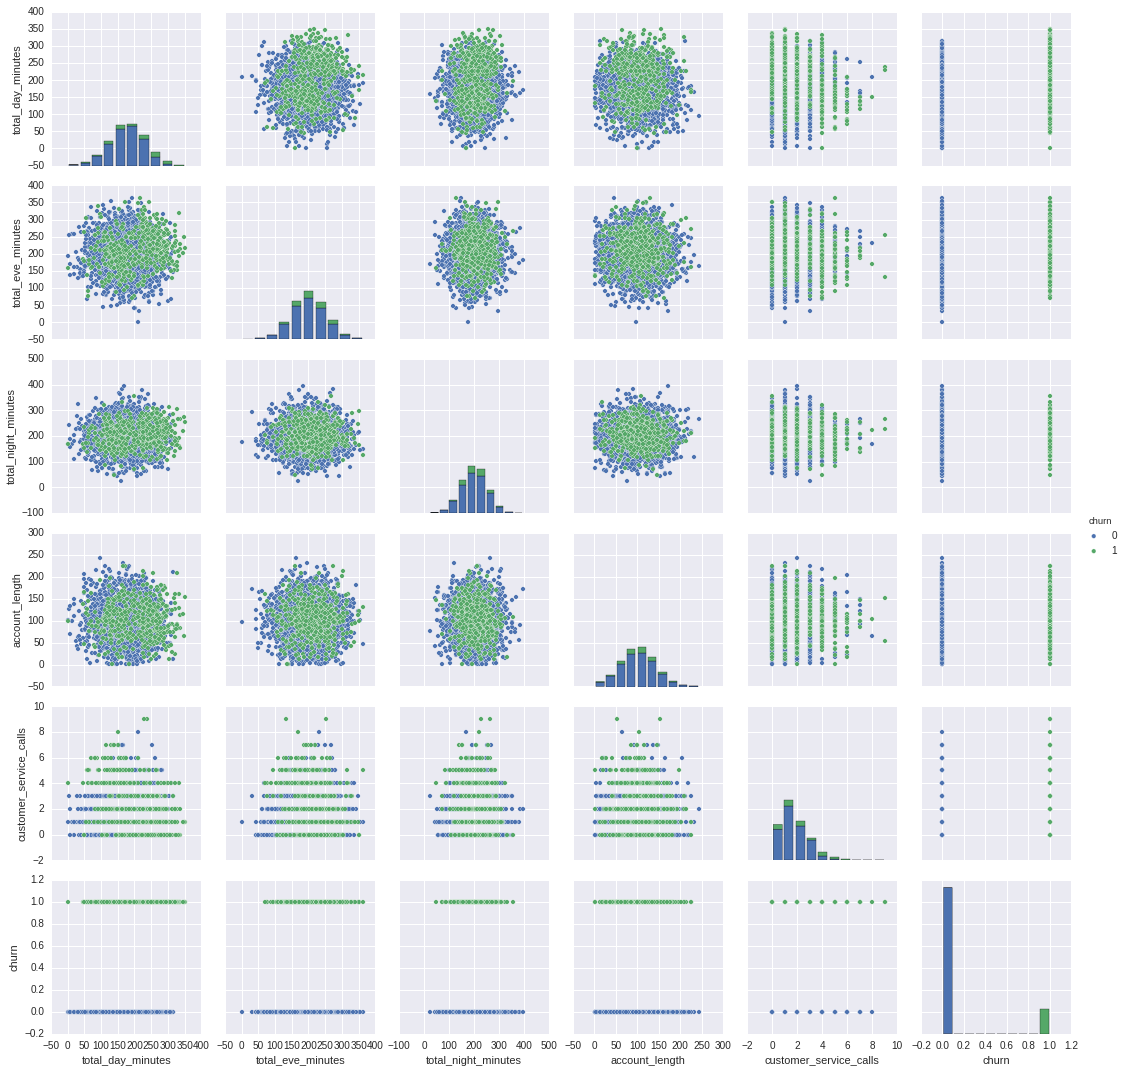

In [8]:
import seaborn as sns
sns.pairplot(data=df[["total_day_minutes",
                      "total_eve_minutes",
                      "total_night_minutes",
                      "account_length",
                      "customer_service_calls",
                      #"area_code",
                      "churn"]],
             hue="churn", dropna=True)
plt.show()

# Algorithm Evaluation
## Experiments
Going to build test harness of test, train, and validation splits using KFolding. Then run predicitions for each fold. Also want to keep track of true positive rate (tpr) and false positive rate (fpr) so I can evaluate receiving operating characteristic curves (ROC's) and the associated area under the curve (AUC) of each. I will also plot the confusion matrix for each model to visualize the predicitve results.

In [9]:
# validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV

In [10]:
def run_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True, random_state=4)
    y_pred = y.copy()
    mean_tpr = 0.0
    mean_acc = 0.0
    mean_prec = 0.0
    mean_recl = 0.0
    mean_f1 = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y[test_index], y_pred[test_index])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        mean_acc += metrics.accuracy_score(y[test_index], y_pred[test_index])
        mean_recl += metrics.recall_score(y[test_index], y_pred[test_index])
        mean_prec += metrics.precision_score(y[test_index], y_pred[test_index])
        mean_f1 += metrics.f1_score(y[test_index], y_pred[test_index])
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    mean_acc /= len(kf)
    mean_recl /= len(kf)
    mean_prec /= len(kf)
    mean_f1 /= len(kf)
    return y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1

def plot_roc(fpr, tpr, auc):
    plt.plot(fpr, tpr, 'k--',label='Mean ROC (area = %0.2f)' % auc, lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

def draw_confusion_matrices(confusion_matrices, class_names):
    labels = list(class_names)
    for cm in confusion_matrices:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm[1])
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.title('%s' % cm[0])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        for i,j in ((x,y) for x in xrange(len(cm[1])) for y in xrange(len(cm[1][0]))):
            val = '{:.1%}'.format(cm[1][i][j]/cm[1].sum())
            ax.annotate(str(val), xy=(i,j), color='white', ha="center", va="center")
        plt.show()

Loading up a bunch of standard machine learning algorithms into test harness. This is a classification problem, so let's try the standard models...

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ARF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import BernoulliRBM as RBM
from sklearn.tree import DecisionTreeClassifier as DT

# accuracy tests for some models
ml_models = []
ml_models.append(["Support Vector Machine", SVC, {}])
ml_models.append(["K-means Nearest Neighbor", KNN, {}])
ml_models.append(["Linear Logistic Regression", LR, {}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
ml_models.append(["Ada Boosted RF", ARF, {'algorithm':'SAMME','n_estimators':200}])

# below model in scikit v0.18 only
#from sklearn.neural_network import MLPClasffifier as NNet
#ml_models.append(["Neural Network", NNet, {'algorithm':'l-bfgs', 'alpha':1e-5,
#                                           'hidden_layer_sizes':(5, 2), 'random_state':123}])

## Measure Performance

Show me the accuracy (acc), precision (prec), recall (recl), confusion matrix (cm), and mean auc for each model.

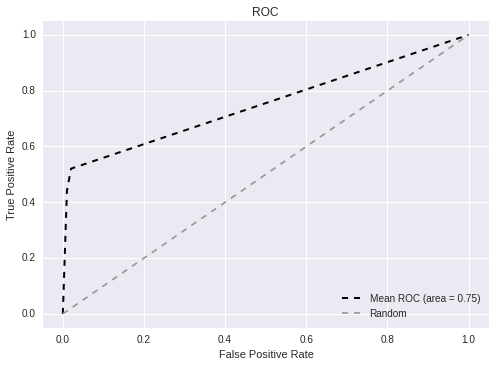

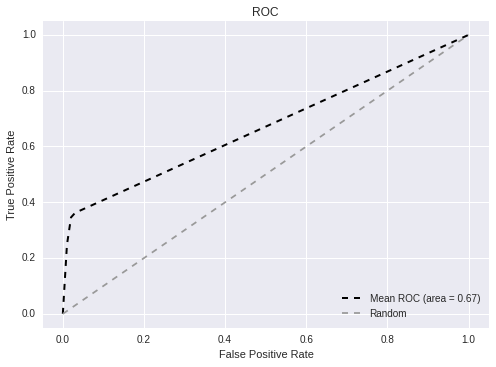

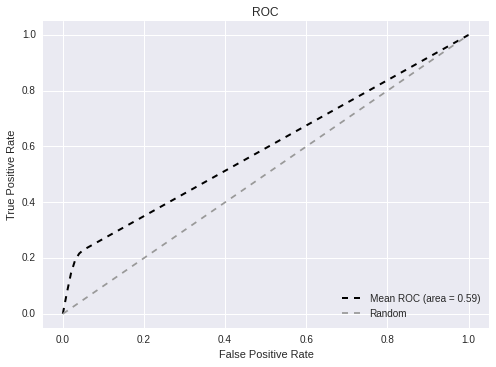

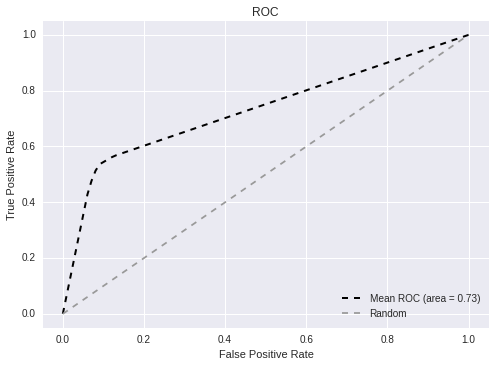

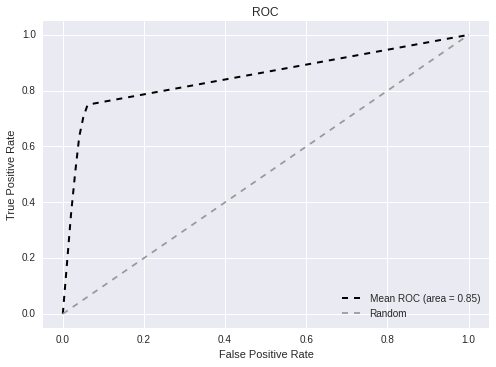

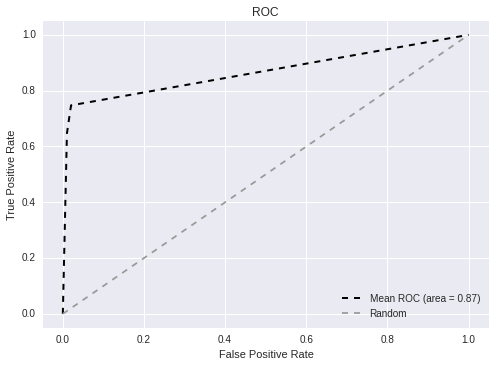

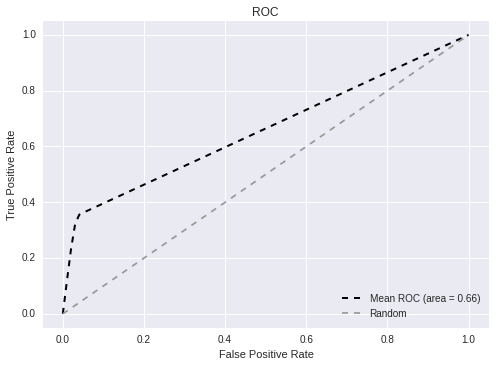

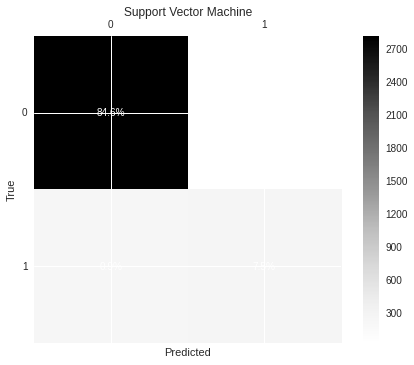

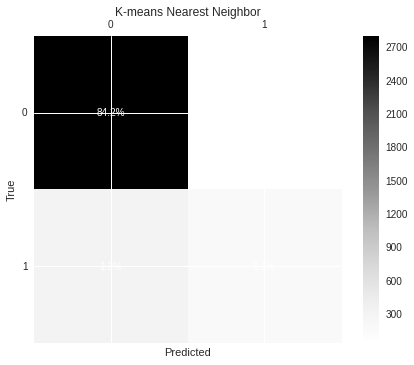

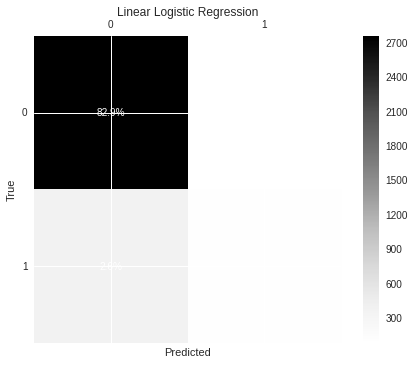

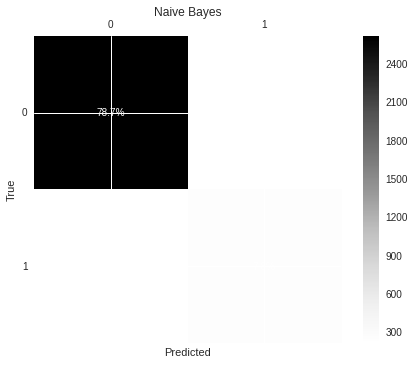

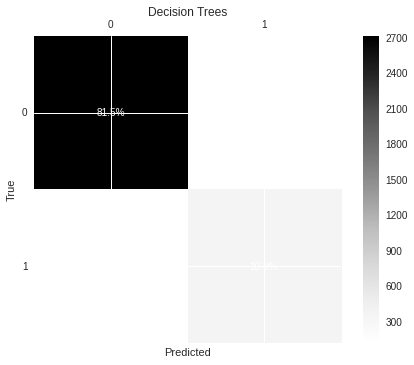

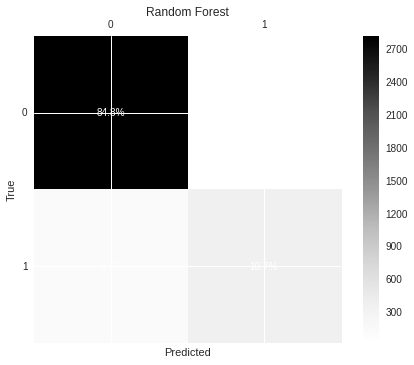

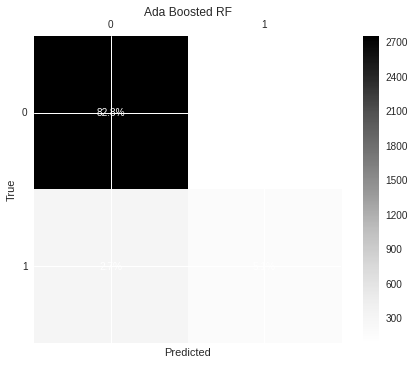

In [12]:
# process each model
from scipy import interp
models = []
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    models.append(m[0])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)

# plot confusion matricies
draw_confusion_matrices(cms, np.unique(y))

In [13]:
models_df = pd.DataFrame.from_items([('model', models),
                              ('accuracy', acc),
                              ('precision', prec),
                              ('recall', recl),
                              ('f1', f1)
                              ])
models_df.sort(['accuracy', 'precision', 'recall', 'f1'], ascending=[False, False, False, False])

,model,accuracy,precision,recall,f1
5,Random Forest,0.955291,0.939566,0.744173,0.828384
4,Decision Trees,0.923198,0.732931,0.745598,0.736344
0,Support Vector Machine,0.920484,0.887533,0.516077,0.650396
1,K-means Nearest Neighbor,0.893480,0.795955,0.352117,0.485283
6,Ada Boosted RF,0.878789,0.650703,0.350077,0.453473
3,Naive Bayes,0.864979,0.537285,0.542841,0.536669
2,Linear Logistic Regression,0.860181,0.543959,0.212721,0.302664


# Testing Results 

In [14]:
# best and worst models
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])

max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])

max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])

max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

Best accuracy:       Random Forest        95.53%
Best precision:      Random Forest        93.96%
Best recall:         Decision Trees       74.56%
Best F1:             Random Forest        82.84%


Random forest is the obvious winner by all measures, so let's take a crack at tuning that model.

## Algorithm Tuning

### Question: What are the important features in the model, and does the model improve when using those features only?

In [19]:
# feature importance
kf = KFold(len(y), n_folds=10, shuffle=True, random_state=4)
y_pred = y.copy()

# keep values for all features
feat_impt = {}
for f in features:
    feat_impt[f] = []

# go through all features    
for train_index, test_index in kf:
    clf = RF(n_estimators=50, min_samples_split=2, n_jobs=-1)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred[test_index] = clf.predict(X_test)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for f in range(X.shape[1]):
        feat_impt[features[indices[f]]].append(importances[indices[f]])

for k in feat_impt:
    val = np.mean(feat_impt[k])
    std = np.std(feat_impt[k])
    feat_impt[k] = val

In [20]:
# sort the features by importance
sorted_feat = sorted(feat_impt.items(), key=operator.itemgetter(1))
sorted_feat.reverse()

# bookkeeping
cumper = 0.
nbr = False

# make a copy of original dataframe to drop unneeded features
X_keep = df

# print out importances
print "item -- feature -- weight -- cumm_weight"
for i, k in enumerate(sorted_feat):
    cumper += k[1]
    
    # tell me when we hit 90% of weights
    if (nbr is False and cumper >= 0.90):
        print '**----  Reached 90%  ----**'
        nbr = True
    print i, k[0], '{:.1%}'.format(k[1]), '{:.0%}'.format(cumper)
    
    # drop unneeded features
    if nbr is True:
        X_keep = X_keep.drop(k[0], axis=1)

item -- feature -- weight -- cumm_weight
0 total_day_charge 14.1% 14%
1 total_day_minutes 14.1% 28%
2 customer_service_calls 11.8% 40%
3 international_plan 8.0% 48%
4 total_eve_charge 6.8% 55%
5 total_eve_minutes 6.7% 61%
6 total_intl_calls 5.4% 67%
7 total_intl_charge 4.3% 71%
8 total_intl_minutes 4.2% 75%
9 total_night_minutes 3.8% 79%
10 total_night_charge 3.7% 83%
11 total_day_calls 3.1% 86%
12 number_vmail_messages 3.1% 89%
**----  Reached 90%  ----**
13 account_length 3.0% 92%
14 total_night_calls 2.8% 95%
15 total_eve_calls 2.7% 98%
16 voice_mail_plan 2.3% 100%


Top 13 features account for 90% of the model weights. Let's try a RF with those features only.

In [21]:
# get names of all features in new df
X_keep = X_keep.drop('churn', axis=1)
features_keep = X_keep.columns
X_keep = X_keep.as_matrix().astype(np.float)

# scale and/or transform X
scaler = StandardScaler()
X_keep = scaler.fit_transform(X_keep)

# checks
print "\n%d observations of %d features" % X_keep.shape
print "Unique labels:", np.unique(y)
print "Gut-check features: %i" % len(features_keep)
print "Gut-check mean: %.4f" % np.mean(X_keep[:,0])
print "Gut-check std: %.4f" % np.std(X_keep[:,0])


3333 observations of 13 features
Unique labels: [0 1]
Gut-check features: 13
Gut-check mean: -0.0000
Gut-check std: 1.0000


Re-run the ML test harness for RF only and see if the model improves (below is cut and paste of earlier code)

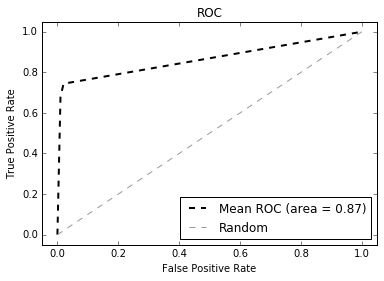

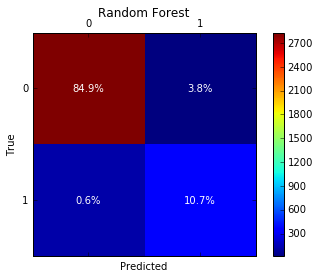

Best accuracy:       Random Forest        95.62%
Best precision:      Random Forest        94.88%
Best recall:         Random Forest        74.04%
Best F1:             Random Forest        82.94%


In [22]:
ml_models = []
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X_keep, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])
max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

* RF predictive power got worse when features contributing < 10% weight were dropped.
* RF predictive power got worse when features contributing < 5% weight were dropped.

**The RF model performs best when all features are included.**

### Question: But is RF superior in its calibration and discrimination?

Calibration measures the difference between actual and predicted probability for individual groups. Discrimination measures the difference between model predictions and the baseline probability. Equations are taken from [Yang, Yates, and Smith (1991)](http://psychology.huji.ac.il/.upload/Ilan/YanivYatesSmith1991PB.pdf).

In [23]:
from operator import idiv

def run_prob_cv(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True)
    y_prob = np.zeros((len(y), 2))
    for train_index, test_index in kf:
        clf = clf_class(**kwargs)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

def calibration(prob, outcome,n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    c = 0.0
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        predicted_prob = np.mean(prob[in_bin])
        true_bin_prob = np.mean(outcome[in_bin])
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob, outcome, n_bins=10):
    prob = np.array(prob)
    outcome = np.array(outcome)
    d = 0.0
    base_prob = np.mean(outcome)
    judgement_bins = np.arange(n_bins + 1) / n_bins
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [24]:
print "Lower calibration and higher discrimination are preferred..."

ml_models = []
ml_models.append(["Support Vector Machine", SVC, {'probability':True}])
ml_models.append(["K-means Nearest Neighbor", KNN, {}])
ml_models.append(["Linear Logistic Regression", LR, {}])
ml_models.append(["Naive Bayes", NB, {}])
ml_models.append(["Decision Trees", DT, {}])
ml_models.append(["Random Forest", RF, {'n_estimators':200, 'random_state':123,
                                        'min_samples_split':2, 'n_jobs':-1}])
ml_models.append(["Ada Boosted RF", ARF, {'algorithm':'SAMME','n_estimators':200}])

cal_err = []
discrim = []
for m in ml_models:
    print "\n"+m[0]
    pred_prob = run_prob_cv(X, y, m[1], **m[2])
    churn_prob, is_churn = pred_prob[:,1], y == 1
    cal_err.append(calibration(churn_prob, is_churn))
    discrim.append(discrimination(churn_prob,is_churn))
    print '{:20} {:.4f}'.format("Calibration Error", cal_err[-1])
    print '{:20} {:.4f}'.format("Discrimination", discrim[-1])
    
idx, value = min(enumerate(cal_err), key=operator.itemgetter(1))
print '{:20} {:20} {:.3%}'.format('\nBest calibration error:', ml_models[idx][0], cal_err[idx])
idx, value = max(enumerate(discrim), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best discrimination:', ml_models[idx][0], discrim[idx])

Lower calibration and higher discrimination are preferred...

Support Vector Machine
Calibration Error    0.0007
Discrimination       0.0673

K-means Nearest Neighbor
Calibration Error    0.0022
Discrimination       0.0453

Linear Logistic Regression
Calibration Error    0.0012
Discrimination       0.0246

Naive Bayes
Calibration Error    0.0194
Discrimination       0.0357

Decision Trees
Calibration Error    0.0144
Discrimination       0.0561

Random Forest
Calibration Error    0.0068
Discrimination       0.0883

Ada Boosted RF
Calibration Error    0.1259
Discrimination       0.0161

Best calibration error: Support Vector Machine 0.066%
Best discrimination: Random Forest        8.83%


### Question: Can we tune the model params to get better results?

In [25]:
from operator import itemgetter

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [26]:
from time import time
from sklearn.grid_search import GridSearchCV

clf = RF(n_jobs=-1)
param_grid = {"n_estimators":[500, 1000],
              "max_depth": [None, 3],
              "max_features": [None, 'auto'],
              "min_samples_split": [4],
              "min_samples_leaf": [1],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

GridSearchCV took 358.95 seconds for 32 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.008)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': None, 'max_depth': None}



**Best scores using X (took 542.40 seconds for 32 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.955 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}


**Best scores using X_keep (took 471.68 seconds for 48 candidate parameter settings):**

Model with rank: 1
Mean validation score: 0.957 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 1000, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.956 (std: 0.006)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.956 (std: 0.007)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 50, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': None}

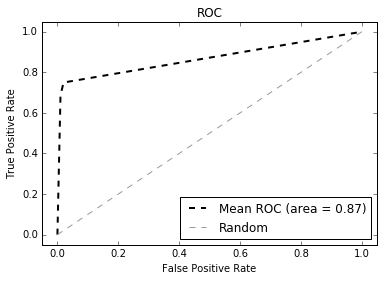

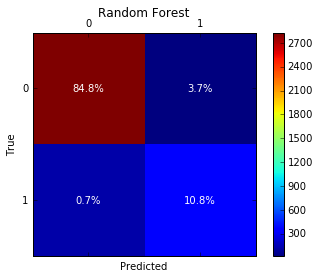

Best accuracy:       Random Forest        95.62%
Best precision:      Random Forest        94.40%
Best recall:         Random Forest        74.64%
Best F1:             Random Forest        83.09%


In [27]:
ml_models = []
ml_models.append(["Random Forest", RF, {'bootstrap': True,
                                        'min_samples_leaf': 1,
                                        'n_estimators': 500,
                                        'min_samples_split': 4,
                                        'criterion': 'entropy',
                                        'max_features': 'auto',
                                        'max_depth': None,
                                        'n_jobs': -1}])
acc = []
prec = []
recl = []
f1 = []
cms = []
aucs = []
for m in ml_models:
    y_pred, mean_fpr, mean_tpr, mean_auc, mean_acc, mean_prec, mean_recl, mean_f1 = run_cv(X, y, m[1], **m[2])
    acc.append(mean_acc)
    prec.append(mean_prec)
    recl.append(mean_recl)
    f1.append(mean_f1)
    cms.append((m[0], metrics.confusion_matrix(y, y_pred)))
    aucs.append(mean_auc)
    plot_roc(mean_fpr, mean_tpr, mean_auc)
draw_confusion_matrices(cms, np.unique(y))
max_idx, max_value = max(enumerate(acc), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best accuracy:', ml_models[max_idx][0], acc[max_idx])
max_idx, max_value = max(enumerate(prec), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best precision:', ml_models[max_idx][0], prec[max_idx])
max_idx, max_value = max(enumerate(recl), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best recall:', ml_models[max_idx][0], recl[max_idx])
max_idx, max_value = max(enumerate(aucs), key=operator.itemgetter(1))
print '{:20} {:20} {:.2%}'.format('Best F1:', ml_models[max_idx][0], f1[max_idx])

**This model is hardly better than the initial guess, but it's technically simpler, so I'll run with this one.**

In [28]:
# Use 10 estimators so predictions are all multiples of 0.1
m = (["Random Forest", RF, {'bootstrap': True,
                            'min_samples_leaf': 1,
                            'n_estimators': 10,
                            'min_samples_split': 1,
                            'criterion': 'entropy',
                            'max_features': 'auto',
                            'max_depth': None,
                            'n_jobs': -1}])
pred_prob = run_prob_cv(X, y, m[1], **m[2])
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1788,0.025168
1,0.1,719,0.029207
2,0.2,238,0.058824
3,0.3,116,0.181034
4,0.8,80,0.950000
5,0.6,74,0.810811
6,0.7,69,0.855072
7,0.9,67,0.985075
8,0.4,64,0.328125
9,1.0,60,1.000000


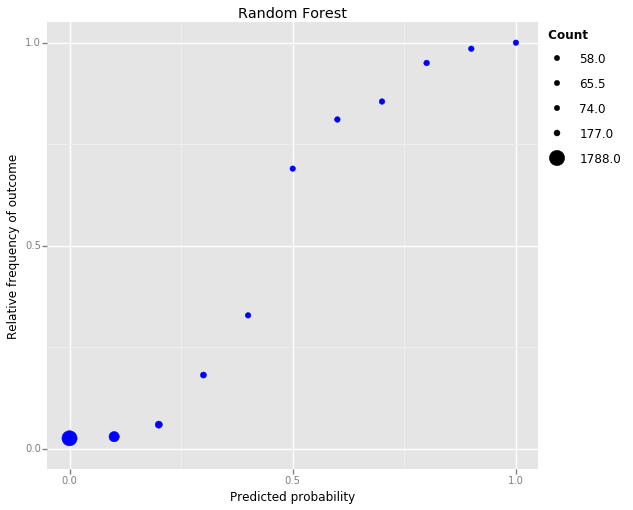

<ggplot: (293617213)>

In [30]:
from ggplot import *
baseline = np.mean(is_churn)
ggplot(counts, aes(x='pred_prob',y='true_prob',size='count')) + \
        geom_point(color='blue') + \
        stat_function(fun = lambda x: x, color='red') + \
        stat_function(fun = lambda x: baseline, color='green') + \
        xlim(-0.05,  1.05) + \
        ylim(-0.05,1.05) + \
        ggtitle("Random Forest") + \
        xlab("Predicted probability") + ylab("Relative frequency of outcome")

Stuff below is collected junk that might be used.

In [ ]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
sig_field = 'sms_count'
signals = df[[c for c in df.columns if c != sig_field]]
labels = df[sig_field]

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })
    
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")

print '{0:.0f}'.format(np.max(median_payout))